# Overview
This notebook tests how the selection of masking threshold value impacts the perfomances of OCT2Hist.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/OCT2Hist-UseModel/blob/main/test_mask_threshold_impact_on_results.ipynb) and run.


In [1]:
# @title Notebook Inputs { display-mode: "form" }
# @markdown Input Image Path
# Path to the OCT image
oct_input_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Raw Data Used In Paper (Paper V2)/LE-03 - Slide04_Section01 (Fig 3.b)/OCTAligned.tiff" # @param {type:"string"}

# OCT image's pixel size
microns_per_pixel_z = 1
microns_per_pixel_x = 1

# @markdown Cropping Parameters
x0 = 130 # @param {type:"slider", min:0, max:1000, step:10}
z0 = 300 # @param {type:"slider", min:0, max:1000, step:10}

# @markdown Signal Threshold (set to left most position to compute threshold by algorithm)
default_min_signal_threshold = 0.4 # @param {type:"slider", min:0.4, max:0.6, step:0.02}
if default_min_signal_threshold==0.4:
  default_min_signal_threshold = -1

## Set Up Environment

In [2]:
if not 'setup_env_oct2Hist_usemodel' in globals():
  setup_env_oct2Hist_usemodel = True
  !git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-ModelInference
  %cd OCT2Hist-ModelInference

import cv2
import matplotlib.pyplot as plt
import numpy as np
import oct2hist
from google.colab import drive
from utils.crop import crop
from utils.masking import mask_image
drive.mount('/content/drive/')

# Set up the environment
oct2hist.setup_network()

Cloning into 'OCT2Hist-ModelInference'...
remote: Enumerating objects: 663, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 663 (delta 84), reused 150 (delta 81), pack-reused 504
Receiving objects: 100% (663/663), 23.20 MiB | 29.36 MiB/s, done.
Resolving deltas: 100% (341/341), done.
Submodule 'pytorch-CycleGAN-and-pix2pix' (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) registered for path 'pytorch-CycleGAN-and-pix2pix'
Cloning into '/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.        
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513        
Receiving objects: 100% (2513/2513), 8.20 MiB | 23.77 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
Submodule path 'pytorch-CycleGAN-and-pix2pix': checked out '9f8f61e5a375c2e01c5187d093ce9c2409f409b0'
/content/OCT2Hist-ModelInference
Mounted at /content/drive/
Drive already mounted

In [3]:
# Inputs are path to the oct image (we can extract the file paths from the oct), and virtual histology images
def display_images(masked_octs,histologies,min_signal_thresholds):
  fig = plt.figure(figsize=(13, 10))

  n = len(min_signal_thresholds)
  for i in range(len(min_signal_thresholds)):
    fig.add_subplot(n, 2, i*2+1)
    plt.imshow(masked_octs[i])
    plt.axis('off')
    if i==0:
      plt.title('Masked OCT')
    plt.text(-25, masked_octs[i].shape[0]/2, '{0:0.2}'.format(min_signal_thresholds[i]),
             fontsize=12, ha='center', va='center', rotation=90)

    fig.add_subplot(n, 2, i*2+2)
    plt.imshow(histologies[i])
    plt.axis('off')
    if i==0:
      plt.title('Virtual Histology')

plt.show()

## Load Image & Make Virtual Histology Using Different Thresholds

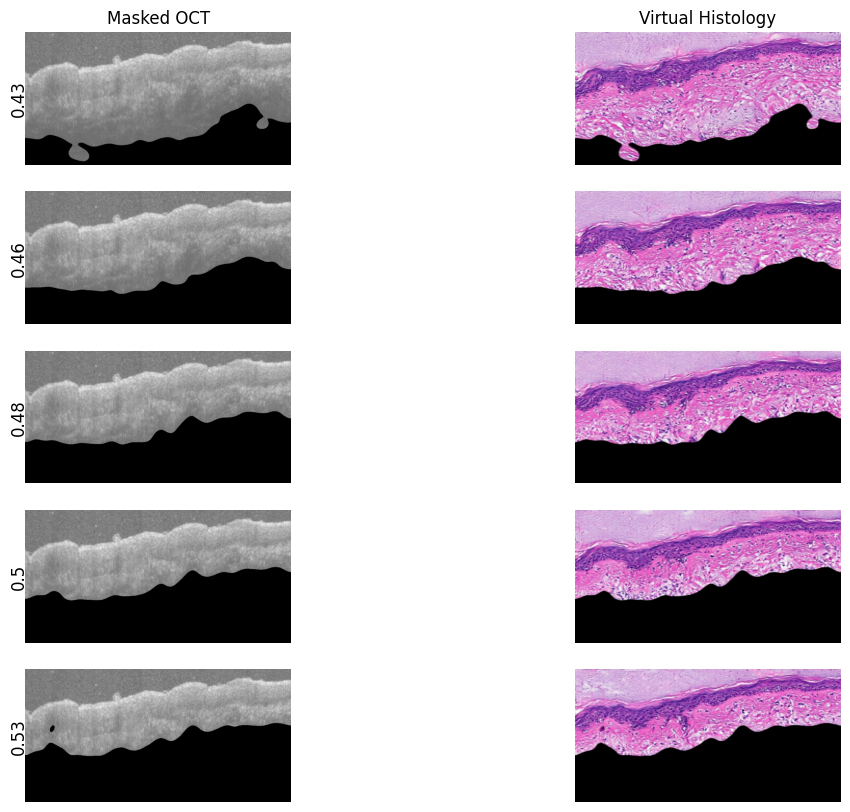

In [6]:
# Load OCT image, crop and compute threshold
oct_image = cv2.imread(oct_input_image_path)
cropped_oct = crop(oct_image, target_width=1024, target_height=512, x0=x0, z0=z0)
if default_min_signal_threshold == -1:
  _,_,_, default_min_signal_threshold  = mask_image(cropped_oct)

# Compute reference histology image, utilizing the default value
histology_ref, *_ = oct2hist.run_network(
    cropped_oct, min_signal_threshold = default_min_signal_threshold)

# Pick some thresholds to explore
min_signal_thresholds = np.array([0.9, 0.95, 1.0, 1.05, 1.1]) * default_min_signal_threshold

# Create container for input and output images
masked_octs = []
histologies = []

# Loop over all threshold and create outputs
for min_signal_threshold in min_signal_thresholds:
  # Run Inference
  histology, *_ = oct2hist.run_network(
      cropped_oct,min_signal_threshold=min_signal_threshold)
  masked_oct, *_ = mask_image(cropped_oct,min_signal_threshold)
  masked_octs.append(masked_oct)
  histologies.append(histology)

# Present results
display_images(masked_octs,histologies,min_signal_thresholds)

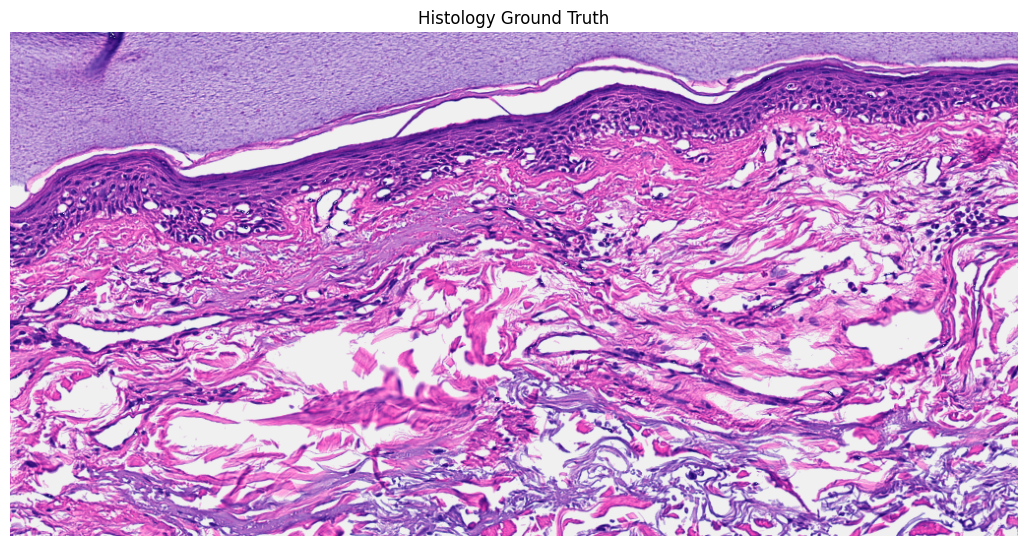

In [8]:
# @title Histology Ground Truth
# Load histology image ground truth
histology_image = cv2.imread(oct_input_image_path.replace(
    "OCTAligned.tiff", "HistologyAligned.tiff"))
histology_image = cv2.cvtColor(histology_image, cv2.COLOR_BGR2RGB)
cropped_histology = crop(histology_image, target_width=1024, target_height=512, x0=x0, z0=z0)

fig = plt.figure(figsize=(13, 10))
plt.imshow(cropped_histology)
plt.axis('off')
plt.title('Histology Ground Truth')
plt.show()